In [296]:
import torch
from mirtorch.prox import prox
from mirtorch.linear import *
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from mirtorch.alg import *

In [343]:
#initial implementation
class FISTA():
    def __init__(self, max_iter, step, fval, grad, prox, momentum = 1, restart = False):
        self.max_iter = max_iter
        self.step = step
        self.fval = fval
        self.grad = grad
        self.prox = prox
        self.momentum = momentum
        self.restart = restart
    '''
    Experimenting different implementation
    '''
    def _update(self):
        #looks like one possible implementation from jeff lecture slides
        step_prev = self.step
        self.step = (1 + np.sqrt(1 + 4*step_prev*step_prev))/2
        self.momentum = (step_prev-1)/self.step
        #print(f'\t Now step={self.step}, momentum={self.momentum}')

    def run_alg(self, x0):
        x_curr = x0
        z_curr = x0 
        for i in range(self.max_iter):
            #print(f'Before iter {i+1}, \n \t z = {z_curr}, x = {x_curr}')
            self._update()
            x_prev = x_curr
            z_prev = z_curr
            #compute new z_k and x_k
            #print(x_curr.shape, z_curr.shape)
            #print(self.grad(x_prev))
            #print(x_prev - self.grad(x_prev))
            z_curr = self.prox(x_prev - self.grad(x_prev))
            #print(f'\tIn iter {i+1}, grad calculated to be {self.grad(x_prev)}')
            x_curr = z_curr + self.momentum * (z_curr - z_prev)
            #x_curr = (1-self.momentum)*z_curr + self.momentum*z_prev
            #print(f'In iter {i}, x_curr calculated to be {x_curr}')
            #update momentum value for next iteration
            #self._update()
        return x_curr

In [93]:
class A(LinearMap):
    def __init__(self):
        super().__init__([2], [2])
        self.mat = torch.Tensor([[2,0],[0,1]])
    def _apply(self, x):
        return torch.matmul(self.mat,x)
    def _apply_adjoint(self,x):
        return self._apply(x)
    
class grad(LinearMap):
    def __init__(self):
        super().__init__([2],[2])
        self._A = A()
    def _apply(self, x):
        y = self._A(x)
        #print(y)
        y -= torch.Tensor([2,1])
        #print(y)
        y = self._A(y)
        return 2/17 * y #17 is needed to account for L lipshitz constant
    

In [94]:
f = FISTA(300, 1, None, grad(), prox.L1Regularizer(.001))

In [97]:
f.run_alg(torch.Tensor([5,5]))

tensor([0.9979, 0.9915])

In [348]:
#Binary classification on MNIST digits using FISTA (specifically 3 and 5)
#get dataset
#uncomment to retech data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.float64)
X_orig, y_orig = X, y
print(len(X))
print(len(X[y==3]))
print(len(X[y==5]))
print(len(X[(y==3) | (y==5)]))

def show_digit(X, y):
    digit_image = X.reshape(28,28)
    print(f'Expected digit {y+4}')
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

70000
7141
6313
13454


(13454, 784) (13454,)
Expected digit 5.0


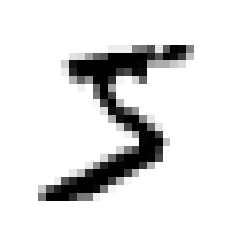

In [349]:
#reduce data to be binary classification for simplicity
X, y = X[(y==3) | (y==5)], y[(y==3) | (y==5)]
y = y - 4
print(X.shape, y.shape)
show_digit(X[0], y[0])
#create train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=3454)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)
#let digit 3 = -1
#let digit 6 = 1



In [361]:
#define grad callable
X_train = X_train.type(torch.float32)
X_test = X_test.type(torch.float32)
y_train = y_train.type(torch.float32)
y_test = y_test.type(torch.float32)
def hubergrad(x, dh = .1):
    if x >= 1:
        return 0
    elif x < 1 and x > 1 - dh:
        return (x-1)/dh
    else:
        return -1
    
def diff_hubergrad(x, dh = .1):
    result = torch.where(x>=1, torch.tensor([0],dtype=torch.float), 
                         torch.where(x<=1-dh, torch.tensor([-1],dtype=torch.float), (x-1)/dh))
    return result

class A(LinearMap):
    def __init__(self, apply_y = True):
        self._A = X_train.clone()
        if apply_y:
            for i in range(self._A.shape[0]):
                self._A[i] *= y_train[i]
        
        super().__init__([28*28], [10000])
    def _apply(self, x):
        return torch.matmul(self._A, x)
    def _apply_adjoint(self, x):
        return torch.matmul(self._A.T, x)
        
class grad:
    def __init__(self, dh=.1, requires_grad=True):
        self.a = A()
        #_,s,_ = torch.svd(self.a._A, compute_uv=False)
        self.L = 1/dh * torch.linalg.norm(self.a._A.T)**2
        self.requires_grad=requires_grad
        
    def __call__(self, x):
        x = self.a(x)
        # it is important that user defined function respects differential operations
        # these two implementations of the same function are different! I can call .backward() on one of them
        # and I can't on the other
        if self.requires_grad:
            x = diff_hubergrad(x)
        else:
            x = x.apply_(hubergrad)
        x = self.a.adjoint(x)
        x = 1/self.L * x
        #print(x)
        return x
def eval(x):
    res = torch.matmul(X_test, x)
    res = torch.sign(res)
    res *= y_test
    total = res.shape[0]
    correct = res[res>0].shape[0]
    print(f'\tCorrect {correct} out of {total} total')
    return correct, total

def gd(n_iter, x, grad):
    for _ in range(n_iter):
        x = x - 1/grad.L*grad(x)
    return x

In [ ]:
f = FISTA(50, 1, None, grad(), prox.L1Regularizer(.001))

tensor(2431864.2500)


	Correct 0 out of 3454 total


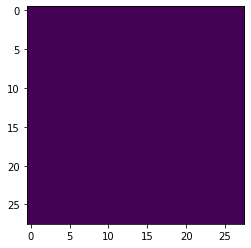

In [352]:
x = torch.zeros(28*28, dtype=torch.float32, requires_grad=True)
res = f.run_alg(x)
res.sum().backward() #can run .backward() on this
eval(res)
plt.imshow(x.grad.data.reshape(28,28).numpy())

res

In [362]:
fsta, grd, cgs = [], [], []
a_mat = A(False)
for i in range(1, 31, 5):
    print(f'Running alg with {i} iterations')
    f = eval(FISTA(i, 1, None, grad(), prox.L1Regularizer(.1)).run_alg(torch.zeros(28*28, dtype=torch.float32)))
    #g = eval(gd(i, torch.zeros(28*28, dtype=torch.float32), grad()))
    cg = CG(a_mat.H*a_mat, i).run(torch.zeros(28*28, dtype=torch.float32), a_mat.H(y_train))
    h = eval(cg)
    fsta.append(f[0]/f[1])
    #grd.append(g[0]/g[1])
    cgs.append(h[0]/h[1])

Running alg with 1 iterations
	Correct 0 out of 3454 total
residual at 1th iter: 28459388633088.0
	Correct 1965 out of 3454 total
Running alg with 6 iterations
	Correct 0 out of 3454 total
residual at 1th iter: 28459388633088.0
residual at 2th iter: 1347280175104.0
residual at 3th iter: 278624239616.0
residual at 4th iter: 170569515008.0
residual at 5th iter: 64597774336.0
residual at 6th iter: 490022731776.0
	Correct 3263 out of 3454 total
Running alg with 11 iterations
	Correct 0 out of 3454 total
residual at 1th iter: 28459388633088.0
residual at 2th iter: 1347280175104.0
residual at 3th iter: 278624239616.0
residual at 4th iter: 170569515008.0
residual at 5th iter: 64597774336.0
residual at 6th iter: 490022731776.0
residual at 7th iter: 52681039872.0
residual at 8th iter: 17762107392.0
residual at 9th iter: 10240568320.0
residual at 10th iter: 177744019456.0
residual at 11th iter: 7442447872.0
	Correct 3298 out of 3454 total
Running alg with 16 iterations
	Correct 0 out of 3454 tot

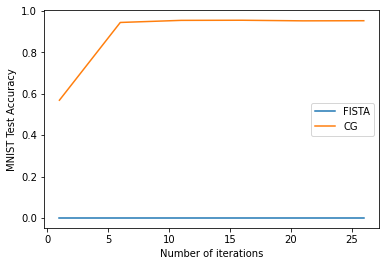

In [363]:
plt.plot([i for i in range(1, 31, 5)], fsta, label='FISTA')
#plt.plot([i for i in range(1, 31, 5)], grd, label='Regular GD')
plt.plot([i for i in range(1, 31, 5)], cgs, label='CG')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('MNIST Test Accuracy')
plt.show()

In [328]:
eval(gd(3000, torch.zeros(28*28, dtype=torch.float32), grad()))

	Correct 3008 out of 3454 total


(3008, 3454)